In [1]:
import sqlite3
import pandas as pd
import fakeInjectionPipeline as fip
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
patch_list = ['00', '11', '22', '33', '44', '55', '66']
host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [23.0, 23.1, 23.2, 23.3, 23.4, 23.5, 23.6, 23.7, 23.8, 23.9, 24.0]
injection_db_path = './data/table/gal_4639/injection_coord.sqlite'

calexp_info_dict, injection_coord_dict = fip.get_calexp_injection_dict(
    patch_list, host_mag_list, dbpath=injection_db_path
)

In [3]:
conn = sqlite3.connect('./data/patch_0to6/diff_faint/al_default/detection/detection.sqlite')
query = (f"SELECT * FROM fake_src")
fake_src_df = pd.read_sql_query(query, conn)

In [20]:
eff_dict = {}
n_of_fake_dict = {}
for host_idx, host_mag in enumerate(host_mag_list):
    efficiency_list = []
    n_of_fake_list = []
    for fake_mag in fake_mag_list:
        fake_mag_str = str(fake_mag).replace('.', '')
        fake_src = fake_src_df.loc[
            np.logical_and(
                fake_src_df.host_mag == host_mag, fake_src_df.fake_mag == fake_mag_str
        )]

        detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
        """
        detected_fake = detected_fake.loc[
            np.abs(detected_fake.base_PsfFlux_instFlux / detected_fake.base_PsfFlux_instFluxErr) > threshold
        ]
        """
        eff = len(detected_fake) / len(fake_src)
        efficiency_list.append(eff)
        n_of_fake_list.append(len(detected_fake))
    eff_dict[host_mag] = efficiency_list
    n_of_fake_dict[host_mag] = n_of_fake_list
    
efficiency_list = []
n_of_fake_list = []    
for fake_mag in fake_mag_list:
    fake_mag_str = str(fake_mag).replace('.', '')
    fake_src = fake_src_df.loc[fake_src_df.fake_mag == fake_mag_str]
    detected_fake = fake_src.loc[fake_src.matched_status.astype(bool)]
    eff = len(detected_fake) / len(fake_src)
    efficiency_list.append(eff)
    n_of_fake_list.append(len(detected_fake))
eff_dict['all'] = efficiency_list
n_of_fake_dict['all'] = n_of_fake_list    

In [21]:
def sigmoid(x, a, b):
    y = 1 / (1 + np.exp( - a * (x - b) ) )
    return y
def fit_eff(fake_mag_list, eff_list):
    popt, pcov = curve_fit(sigmoid, fake_mag_list, eff_list, bounds=((-20, 0),(0, 50)))
    m50 = - 1 / popt[0] * np.log(1 / 0.5 - 1) + popt[1]
    x_ls = np.arange(23, 24.009, 0.01)
    y_ls = []
    for x in x_ls:
        y = sigmoid(x, popt[0], popt[1])
        y_ls.append(y)
    return m50, y_ls

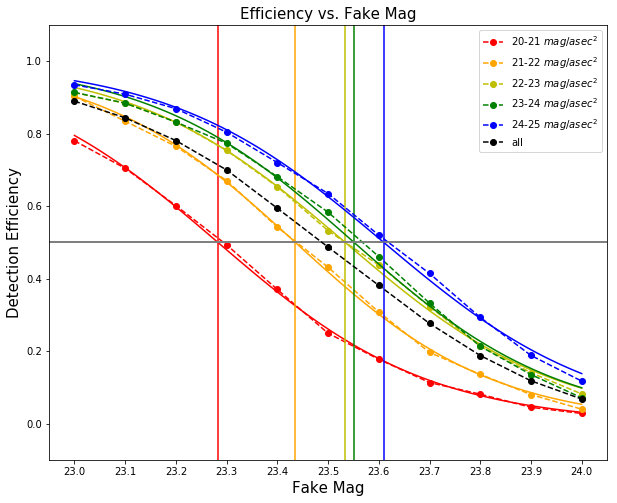

In [27]:
color_list=['r', 'orange', 'y', 'g', 'blue', 'k']

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for host_idx, host_mag in enumerate(host_mag_list):
    mag = host_mag.split('_')
    color = color_list[host_idx]
    m50, y_ls = fit_eff(fake_mag_list, eff_dict[host_mag])
    ax.axvline(x=m50, color=color)
    ax.plot(x_ls, y_ls, color=color)
    ax.plot(fake_mag_list, eff_dict[host_mag], marker='o', ls='--', color=color, label=f'{mag[0]}-{mag[1]} $mag / asec^2$')
    ax.axhline(y=0.5,color='gray')
m50, y_ls = fit_eff(fake_mag_list, eff_dict[host_mag])
ax.plot(fake_mag_list, eff_dict['all'], marker='o', ls='--', color='k', label='all')
ax.set_xticks(fake_mag_list)
ax.set_xticklabels(fake_mag_list)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('Fake Mag', size=15)
ax.set_ylabel('Detection Efficiency', size=15)
ax.set_title('Efficiency vs. Fake Mag', size=15)
ax.legend()
plt.savefig('faint_end.pdf',dpi=100)